###### <h1>Bearing Data Analysis </h1> <h2>This Notebook Demonstrates</h2> <ul> <li>Getting data from sensorcloud</li> <li>Splitting entire data set into a list of bursts</li> <li>Performing FFTs </li> <li>Graphing time history data </li> <li>Graphing frequency domain </li> <li>Graphing RMS Amplitude and Crest factor vs time </li> <li>Spectrograph of fft's</li> </ul>

In [1]:
import numpy as np
import matplotlib
from math import cos
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from MathEngine import FFT as meFFT

matplotlib.rcParams['figure.figsize'] = (12,5)
matplotlib.rcParams['savefig.dpi'] = 100

In [2]:
#bearing info

xRPM = 1700
xFreq = xRPM/60.0
xFreq

#S Revolutions per second 
S = xFreq
#ball Diameter, solver gets 8.3357, ruler gets 6.0
Bd = 6.0
#Number of Balls
Nb = 14
#Pitch Diameter
Pd = 51

#Contact angle
Phi = 0

print "Rotational frequency:                       " + "{0:.5f}".format(xFreq)

#FTF, Fundamental train frequency (FTF)
FTF = S * 0.5 * ( 1.0 - (Bd/Pd) * cos(Phi))
print "FTF,   Fundamental train frequency:         " + "{0:.5f}".format(FTF)

#BSF, Ball spin frequency
BSF = S * (Pd/(2*Bd))*(1-(Bd/Pd)**2 * cos(Phi)**2)
print "BSF,   Ball spin frequency:                 " + "{0:.5f}".format(BSF)

#BPFI, Ball pass frequency inner race
BPFI = S * (Nb/2)*(1+(Bd/Pd)*cos(Phi))
print "BPFI,  Ball pass frequency inner race:      " + "{0:.5f}".format(BPFI)

#BPFO, Ball pass frequency outer race
BPFO = S * (Nb/2)*(1-(Bd/Pd)*cos(Phi))
print "BPFO,  Ball pass frequency outer race:      " + "{0:.5f}".format(BPFO)

#BPFPe, Estamated ball pass frequency
BPFOe = ((Nb/2)-1.2)*S
print "BPFOe, Ball pass frequency outer race est:  " + "{0:.5f}".format(BPFOe)

Rotational frequency:                       28.33333
FTF,   Fundamental train frequency:         12.50000
BSF,   Ball spin frequency:                 118.75000
BPFI,  Ball pass frequency inner race:      221.66667
BPFO,  Ball pass frequency outer race:      175.00000
BPFOe, Ball pass frequency outer race est:  164.33333


In [3]:
repo = TimeSeriesRepo('FFFF0015C92A4840')

#entire dat set
#allSeries = repo.getAllTimeSeries( '96', 'ch1', startTime=1397661208021542000, endTime=1397669095623446000 )

#first half of data set
allSeries = repo.getAllTimeSeries( '96', 'ch1', startTime=1397661157713273000, endTime=1397665650015541000 )

#first four bursts
#allSeries = repo.getAllTimeSeries( '96', 'ch1', startTime=1397661211814921000, endTime=1397661653626747000 ) 

In [4]:
series = allSeries[0]

In [5]:
timestamps = series.getTimeStamps()
data = series.getData()

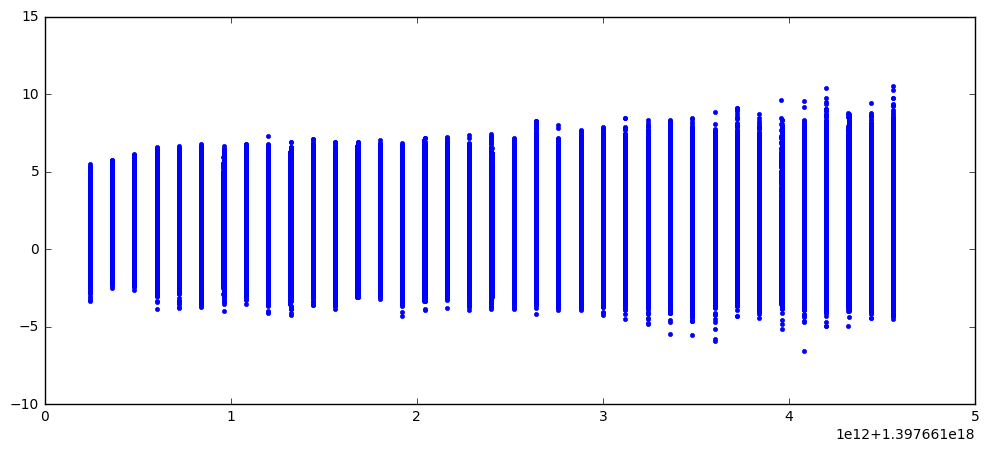

In [6]:
plt.plot(timestamps, data, ls = ' ', marker = '.')

In [7]:
expectedTimePeriod = (1.0/series.getSampleRate())*NANO_PER_SEC
#print expectedTimePeriod

In [8]:
bursts = [] # List of detected burst segments
oldPoint = series[0]
tmp_points = []

for i, point in enumerate(series):
    tmp_points.append(point)
    difference = point[0] - oldPoint[0]
            
    # If a gap in data is detected we assume we are at the end of a burst
    if difference > 1000*expectedTimePeriod:
        #print difference
        bursts.append(tmp_points)
        tmp_points = []
    oldPoint = point
bursts.append(tmp_points)
del tmp_points
print len(bursts), 'bursts found'

37 bursts found


In [9]:
def filterSignal(values, sampleRate, filterType, order, freq1, freq2 = None):
    from scipy.signal import butter, filtfilt
    
    assert filterType in ['highpass', 'lowpass', 'bandpass', 'bandstop'], "Filter type must be 'highpass','lowpass','bandpass' or 'bandstop'"
    
    nyquistRate = sampleRate/2
    
    if filterType == 'bandpass' or filterType == 'bandstop':
        high = freq2/nyquistRate
        low = freq1/nyquistRate
        wn = [low,high]
    elif filterType == 'lowpass':
        wn = freq1/nyquistRate
    elif filterType == 'highpass':
        wn = freq1/nyquistRate
    
    b, a = butter(order, wn, btype=filterType)
    filtered = filtfilt(b, a, values)
    
    return filtered

def getFft(values, samplerate, xMin = None, xMax = None):
    import numpy as np
    out = np.absolute(np.fft.fft(values))
    freq = np.fft.fftfreq(out.size, 1.0/samplerate)
    
    out = out[1:len(out)/2]
    freq = freq[1:len(freq)/2]
    
    if xMin == None or xMin < 0.1:
        xMin = 0.1
    for i, value in list(enumerate(freq)):
        if value >= xMin:
            freq = freq[i:]
            out = out[i:]
            break
    
    if xMax != None:
        for i, value in reversed(list(enumerate(freq))):
            if value <= xMax:
                freq = freq[:i]
                out = out[:i]
                break
        
    return (out, freq)
def getPsdFft(values, samplerate, xMin = None, xMax = None):
    import numpy as np
    out = np.absolute(np.fft.fft(values))**2
    freq = np.fft.fftfreq(out.size, 1.0/samplerate)
    
    out = out[1:len(out)/2]
    freq = freq[1:len(freq)/2]
    
    if xMin == None or xMin < 0.1:
        xMin = 0.1
    for i, value in list(enumerate(freq)):
        if value >= xMin:
            freq = freq[i:]
            out = out[i:]
            break
    
    if xMax != None:
        for i, value in reversed(list(enumerate(freq))):
            if value <= xMax:
                freq = freq[:i]
                out = out[:i]
                break
        
    return (out, freq)

In [10]:
print series.getSampleRate()

50000


In [11]:
slope = 1
offset = 0
minFreq = 0
#maxFreq = series.getSampleRate()/2.0
maxFreq = 10000
waterfall = []
maxVal = 0
fftValues = []
freqValues = [] 

for burst in bursts:
    scaledData = (np.array( map(lambda x: x[1], burst) )*slope) + offset
    fft, freq = getFft(scaledData, series.getSampleRate(), xMin = minFreq, xMax = maxFreq)
    fftValues.append(fft)
    freqValues.append(freq)
    fft[-1] = 0
    fft[0] = 0
    curMax = np.amax(fft/len(burst))
    if curMax > maxVal:
        maxVal = curMax
    waterfall.append(zip(freq,fft/len(burst)))
segments = len(bursts)

In [12]:
#The RMS value of a set of values is the square root of the arithmetic mean (average) of the squares of the original values

def rmsAmplitude(values):
    returnValue = 0
    for x in values:
        returnValue += x**2
    returnValue = returnValue/len(values)
    returnValue = np.sqrt(returnValue)
    return returnValue

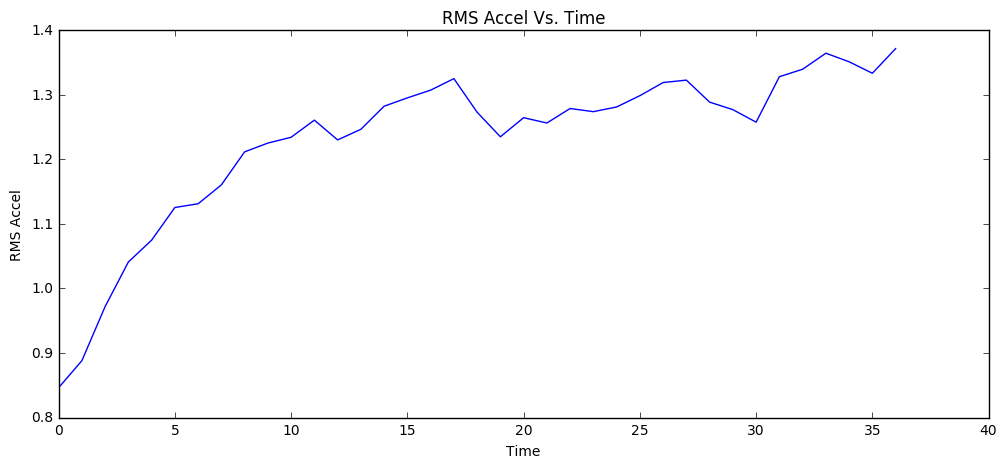

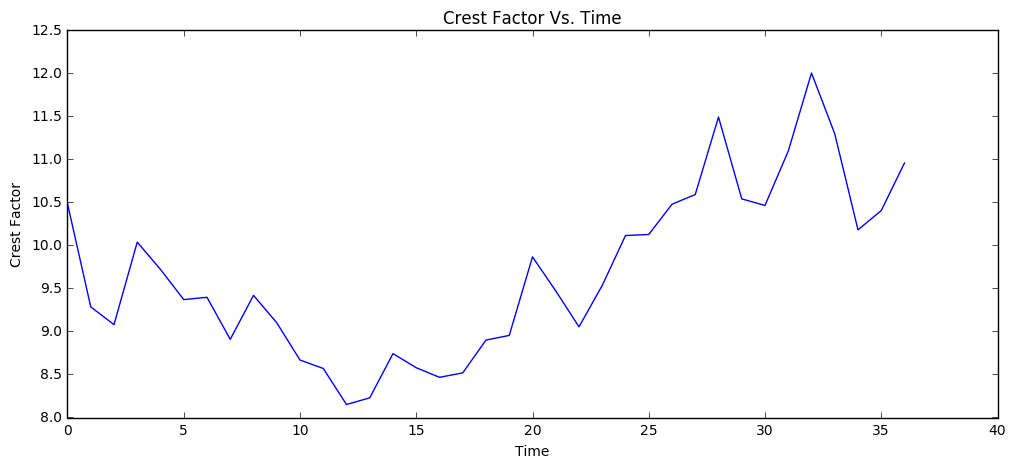

In [13]:
rmsValue = []
crestFactorValue = []
tempValue = []
burstTimestamps = []

for burst in bursts:
    scaledData = (np.array( map(lambda x: x[1], burst) )*slope) + offset
    burstTimestamps.append(np.array( map(lambda x: x[0], burst)))
    meanValue = np.mean(scaledData)
    rmsValue.append(rmsAmplitude(scaledData))
    ptp = np.ptp(scaledData)
    crestFactorValue.append(abs(ptp)/(rmsValue[-1]))
    #print '-----------------'
    #print len(scaledData), 'points in array'
    #print 'mean:        ', meanValue
    #print 'rms:         ', rmsValue[-1]
    #print 'ptp:         ', ptp  
    #print 'crest factor:', crestFactorValue[-1]

plt.figure(0)
plt.plot(rmsValue)
plt.xlabel('Time')
plt.ylabel('RMS Accel')
plt.title('RMS Accel Vs. Time')
plt.figure(1)
plt.plot(crestFactorValue)
plt.xlabel('Time')
plt.ylabel('Crest Factor')
plt.title('Crest Factor Vs. Time')

In [14]:
firstTimestampBurst = []
for x in burstTimestamps:
    firstTimestampBurst.append(x[0])

In [15]:
#output data to back to sensorcloud
#make new channel names or delete each time
#120 here represents the burst rate (2 min) 

outData1 = zip(firstTimestampBurst, rmsValue)
outData2 = zip(firstTimestampBurst, crestFactorValue)

#outSeries1 = repo.createTimeSeries('96', 'ch1_rms_1',  120, 'seconds')
#outSeries1.push(outData1)
#outSeries1.save()
#outSeries1.tagAsMathengine()

#outSeries2 = repo.createTimeSeries('96', 'ch1_crest_factor_1',  120, 'seconds')
#outSeries2.push(outData2)
#outSeries2.save()
#outSeries2.tagAsMathengine()

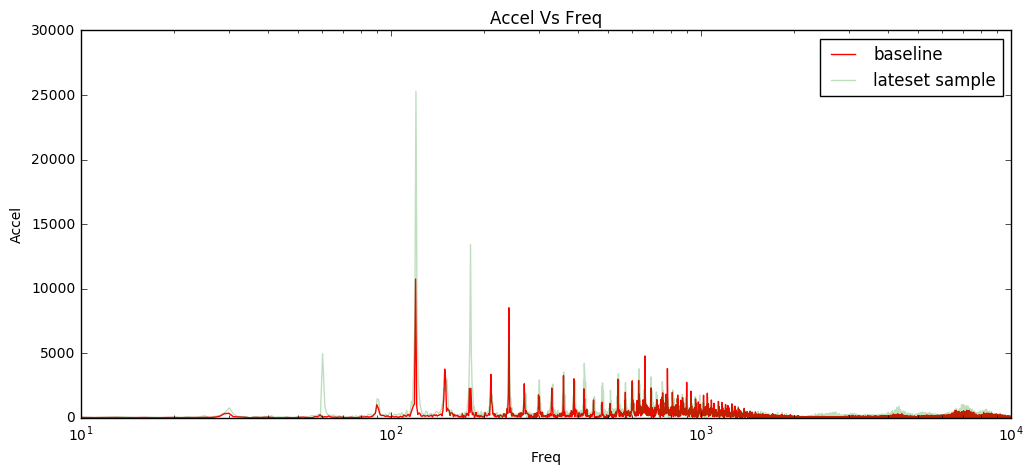

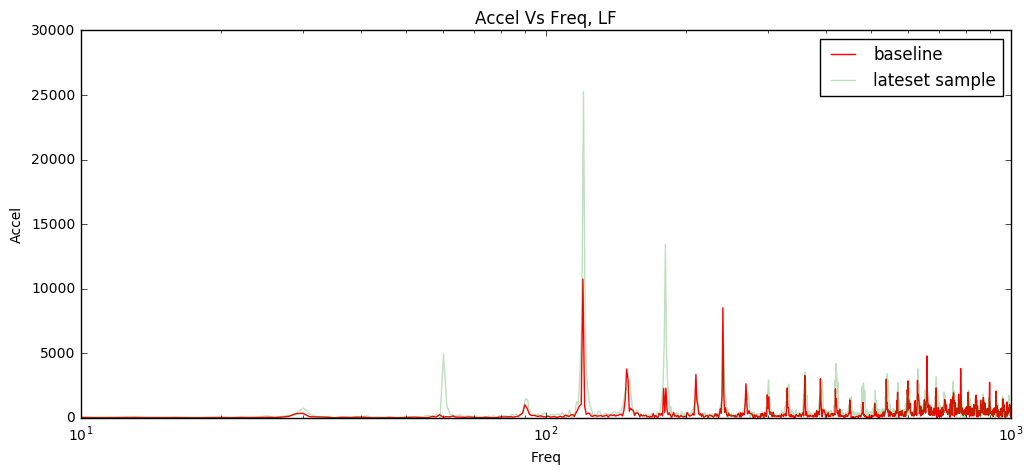

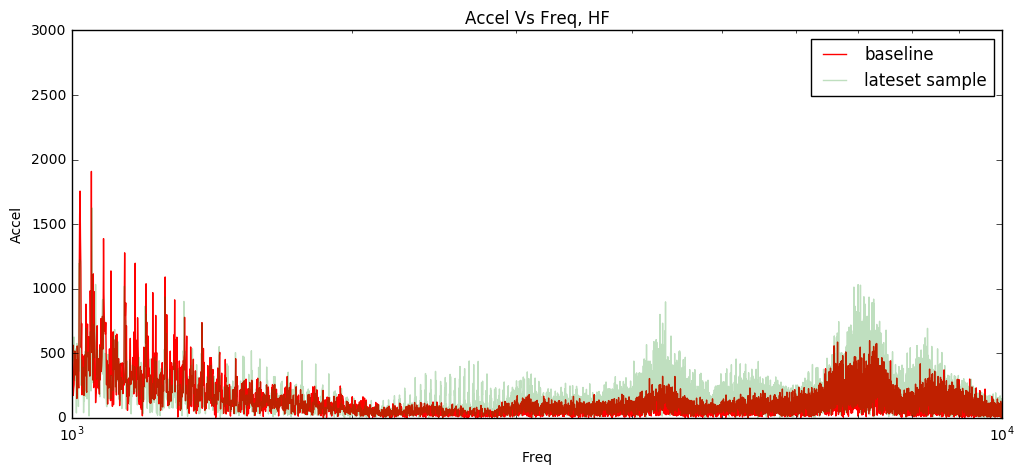

In [16]:
xmin = 10
xmax = 10000
ymin = 0
ymax = 30000

plt.figure(3)
plt.plot(freqValues[0], fftValues[0], color = 'r', alpha = 1, label = 'baseline')
plt.plot(freqValues[-1], fftValues[-1], color = 'g', alpha = .25, label='lateset sample')

plt.xlabel('Freq')
plt.ylabel('Accel')
plt.title('Accel Vs Freq')
plt.xscale('log')
plt.axis([xmin,xmax,ymin,ymax])
plt.legend(loc='upper right')

#--------------------------------------------------------------------------------------

xmin = 10
xmax = 1000
ymin = 0
ymax = 30000

plt.figure(4)
plt.plot(freqValues[0], fftValues[0], color = 'r', alpha = 1, label = 'baseline')
plt.plot(freqValues[-1], fftValues[-1], color = 'g', alpha = .25, label='lateset sample')

plt.xlabel('Freq')
plt.ylabel('Accel')
plt.title('Accel Vs Freq, LF')
plt.xscale('log')
plt.axis([xmin,xmax,ymin,ymax])
plt.legend(loc='upper right')

#--------------------------------------------------------------------------------------

xmin = 1000
xmax = 10000
ymin = 0
ymax = 3000

plt.figure(5)
plt.plot(freqValues[0], fftValues[0], color = 'r', alpha = 1, label = 'baseline')
plt.plot(freqValues[-1], fftValues[-1], color = 'g', alpha = .25, label='lateset sample')

plt.xlabel('Freq')
plt.ylabel('Accel')
plt.title('Accel Vs Freq, HF')
plt.xscale('log')
plt.axis([xmin,xmax,ymin,ymax])
plt.legend(loc='upper right')

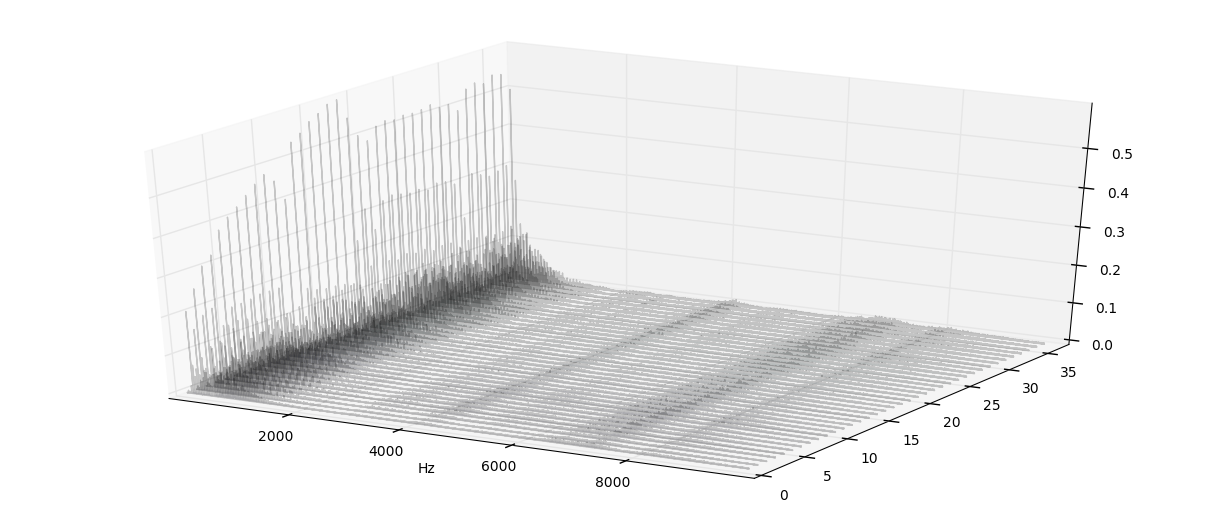

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
    
colors = [cm.bone(i) for i in np.linspace(0.2,1,segments)]
col = PolyCollection( waterfall , facecolors = colors)
col.set_alpha(.2)
ax.add_collection3d(col, zs=np.arange(0,segments),zdir='y')

ax.set_yscale('linear')
ax.set_xlabel('Hz')
ax.set_xlim(freq[0],freq[-1])
ax.set_ylim(0,segments)

maxAmp = 0.6

if maxAmp == 0 or maxAmp > maxVal:
    ax.set_zlim(0,maxVal)
else:
    ax.set_zlim(0,maxAmp)